In [9]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(GGally)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [25]:
forest_fire<-read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv', skip=1)%>%
    select(-day, -month, -year)%>%
        filter(Classes!='Classes',
                Temperature!='NA',
                  RH!='NA',
                  Rain!='NA',
                    Ws!='NA',
                   FFMC!="NA",
                   DMC!="NA",
                   DC!="NA",
                   ISI!="NA",
                   BUI!="NA",
                   FWI!="NA") %>%
    mutate(Classes=as_factor(Classes),
        Temperature=as.numeric(Temperature),   
        RH=as.numeric(RH),
        Rain=as.numeric(Rain),
        Ws=as.numeric(Ws),
        FFMC=as.numeric(FFMC),
        DMC=as.numeric(DMC),
        DC=as.numeric(DC),
        ISI=as.numeric(ISI),
        BUI=as.numeric(BUI),
        FWI=as.numeric(FWI)) 

forest_fire

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”


Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire
33,54,13,0.0,88.2,9.9,30.5,6.4,10.9,7.2,fire
30,73,15,0.0,86.6,12.1,38.3,5.6,13.5,7.1,fire
25,88,13,0.2,52.9,7.9,38.8,0.4,10.5,0.3,not fire


In [26]:
summary_by_fire_status <- group_by(forest_fire, Classes) %>%
  summarize(
    Rain = mean(Rain),
    RH = mean(RH),
    Ws= mean(Ws),
     Temperature= mean(Temperature	) 
    
  )
summary_by_fire_status

`summarise()` ungrouping output (override with `.groups` argument)



Classes,Rain,RH,Ws,Temperature
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
not fire,1.62452830,69.31132,15.71698,30.02830
fire,0.09635036,56.41606,15.32117,33.79562


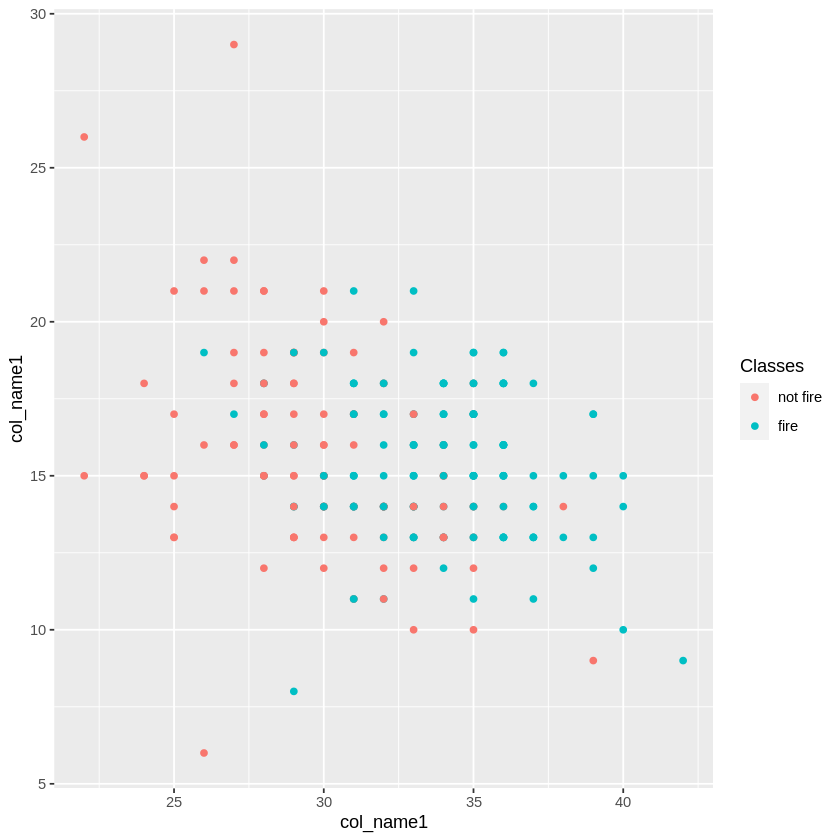

In [27]:
vacc_plot<- forest_fire%>%
    ggplot(aes(x= Temperature, y= Ws, color=Classes))+
    geom_point()+
    xlab('col_name1')+
    ylab('col_name1')
vacc_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



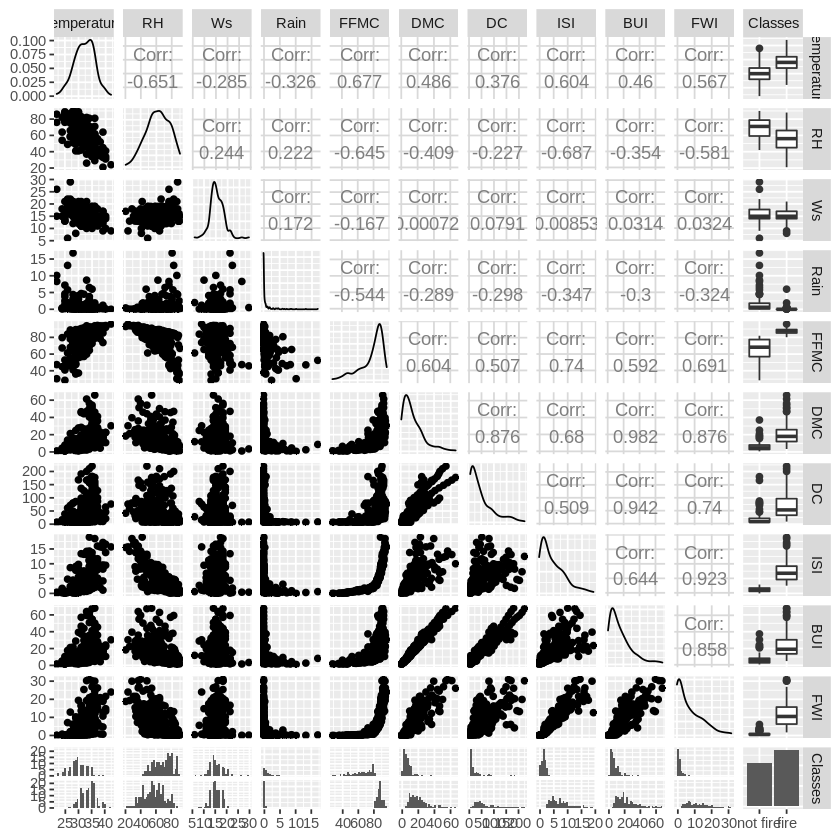

In [28]:
correlation_graph <- forest_fire %>%
    ggpairs(columns = 1:11)
correlation_graph